In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_classif
from xverse.ensemble import VotingSelector


This notebook was just solely for me to gather some sense what the data is. It is not intended to be represented in front of people.

In [5]:
df = pd.read_csv('data/fraude_detection.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [6]:
df[['EJ']].value_counts()

EJ
B     395
A     222
Name: count, dtype: int64

In [155]:
df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Target
0,298989cc4e92,2.615076,2311.11936,2353.415652,96.700728,150.397920,118.852344,0.745416,155.180448,55.999104,...,2.078748,8.86704,4.388904,198.690720,6812.763132,152615.473440,307.786236,1952.240592,263.736000,no_fraud
1,d02c11462079,9.024576,35279.18592,1022.401764,177.978396,97.664256,43.373664,0.306936,119.410296,14.758800,...,48.791881,24.69756,1.625520,148.013424,871.332756,70493.693472,298.632576,247.745328,1.291651,no_fraud
2,c82e5a429e5b,5.896740,33281.45172,1022.401764,165.119652,97.664256,43.905204,0.314244,169.397760,14.758800,...,28.816302,5.96472,3.494868,188.198064,1031.060310,10456.029504,450.449376,1267.214112,4.238270,no_fraud
3,cc42ed28ac3f,4.666116,27652.12032,1022.401764,359.227224,97.664256,69.312816,0.332514,115.855968,14.758800,...,39.198823,14.00004,4.795284,145.892568,871.332756,548283.454440,440.491980,405.645552,3.739279,no_fraud
4,ea50b3c5bd63,3.948252,15830.40096,1022.401764,85.179888,97.664256,34.443792,0.306936,190.799352,78.179472,...,33.737781,5.96472,9.184188,291.115392,1494.951318,96115.763160,392.133864,808.266432,22.572000,no_fraud


In [156]:
df.columns

Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Target'],
      dtype='object')

In [157]:
print(f'The dataset has {df.shape[0]} observations and {df.shape[1]} features.')

The dataset has 617 observations and 58 features.


In [163]:
df_sorted = sorted(df.isnull().sum().items(), key=lambda x: x[1], reverse=True)
df_sorted = pd.DataFrame(df_sorted, columns=['Feature', 'Missing Values'])
df_sorted['Missing Values (%)'] = (df_sorted['Missing Values'] / df.shape[0]) * 100
df_sorted = df_sorted[df_sorted['Missing Values'] > 0]
df_sorted = df_sorted.sort_values(by='Missing Values (%)', ascending=False)
df_sorted

,Feature,Missing Values,Missing Values (%)
0,BQ,60,9.724473
1,EL,60,9.724473
2,CC,3,0.486224
3,CB,2,0.324149
4,FS,2,0.324149
5,DU,1,0.162075
6,FC,1,0.162075
7,FL,1,0.162075
8,GL,1,0.162075


In [7]:
df['EJ_enc'] = df['EJ'].apply(lambda x: 0 if x == 'A' else 1)

In [ ]:
cols = [col for col in df.columns if col not in ['Id', 'Target','EJ']]

# impute with the median - best for skewed data
for col in cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

C:\Users\magggien\AppData\Local\Temp\ipykernel_4208\522087277.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
C:\Users\magggien\AppData\Local\Temp\ipykernel_4208\522087277.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [176]:
df_sorted = sorted(df.isnull().sum().items(), key=lambda x: x[1], reverse=True)
df_sorted = pd.DataFrame(df_sorted, columns=['Feature', 'Missing Values'])
df_sorted['Missing Values (%)'] = (df_sorted['Missing Values'] / df.shape[0]) * 100
df_sorted = df_sorted[df_sorted['Missing Values'] > 0]
df_sorted = df_sorted.sort_values(by='Missing Values (%)', ascending=False)
df_sorted

,Feature,Missing Values,Missing Values (%)


In [177]:
# Simple approach - creates a new dataframe with range column
ranges_df = df.select_dtypes(include=[np.number]).apply(
    lambda x: f"({x.min()}, {x.max()})"
).to_frame('range')
ranges_df

,range
AB,"(0.974244, 73.939992)"
AF,"(2311.11936, 344258.25192)"
AH,"(1022.401764, 22921.478376)"
AM,"(38.130264, 7566.21876)"
AR,"(97.664256, 2147.323608)"
AX,"(8.398332, 459.25056)"
AY,"(0.306936, 123.790212)"
AZ,"(40.761336, 467.658816)"
BC,"(14.7588, 17564.321376)"
BD,"(20323.49184, 636727.19088)"


In [78]:
min_value = df.select_dtypes(include=[np.number]).min().min()
max_value = df.select_dtypes(include=[np.number]).max().max()
print(f'Minimum value in the dataset: {min_value}')
print(f'Maximum value in the dataset: {max_value}')

Minimum value in the dataset: 0.013551336
Maximum value in the dataset: 2151003.0348


In [9]:
df['Target_enc'] = df['Target'].apply(lambda x: 0 if x == 'no_fraud' else 1)

In [10]:
feature_cols = [col for col in df.columns if col not in ['Id', 'Target', 'Target_enc', 'EJ']]

# Compute Spearman and Kendall correlation
spearman_results = []
kendall_results = []

for col in feature_cols:
    vals = df[[col, 'Target_enc']].dropna()
    sp_corr, _ = spearmanr(vals[col], vals['Target_enc'])
    spearman_results.append((col, sp_corr))
    kd_corr, _ = kendalltau(vals[col], vals['Target_enc'])
    kendall_results.append((col, kd_corr))

In [8]:
# Sort and display top features by absolute correlation
spearman_results = sorted(spearman_results, key=lambda x: abs(x[1]), reverse=True)
kendall_results = sorted(kendall_results, key=lambda x: abs(x[1]), reverse=True)

print("Top 10 Features by Spearman Correlation:")
for feature, corr in spearman_results[:10]:
    print(f"{feature:10} {corr:.3f}")

print("\nTop 10 Features by Kendall Correlation:")
for feature, corr in kendall_results[:10]:
    print(f"{feature:10} {corr:.3f}")

Top 10 Features by Spearman Correlation:
AB         0.287
DU         0.277
CR         -0.272
BQ         0.265
AF         0.260
FL         0.259
GL         -0.258
BC         0.222
DF         0.221
BN         0.213

Top 10 Features by Kendall Correlation:
DU         0.238
AB         0.235
CR         -0.223
FL         0.222
GL         -0.221
BQ         0.218
AF         0.212
DF         0.209
BC         0.199
BN         0.177


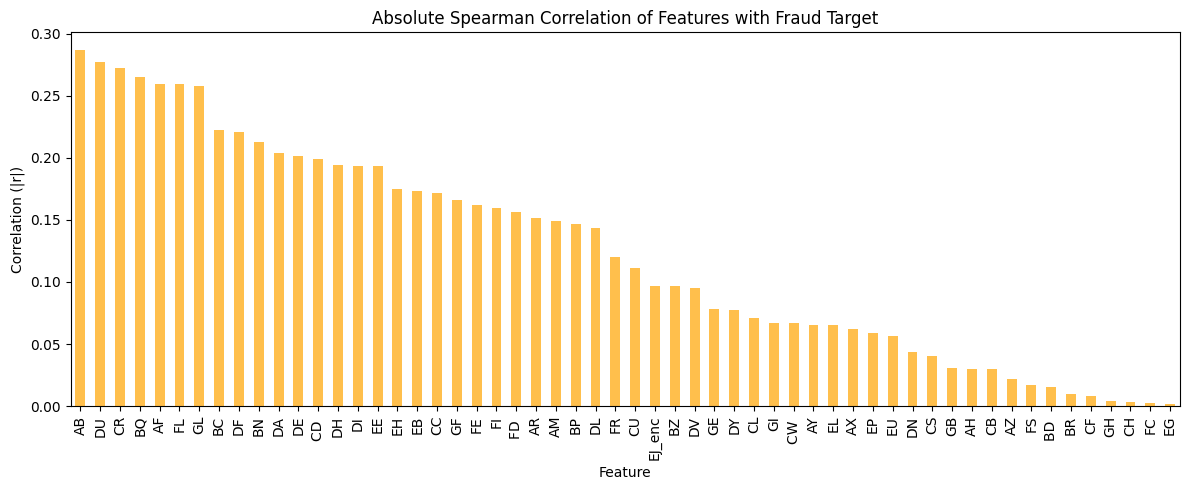

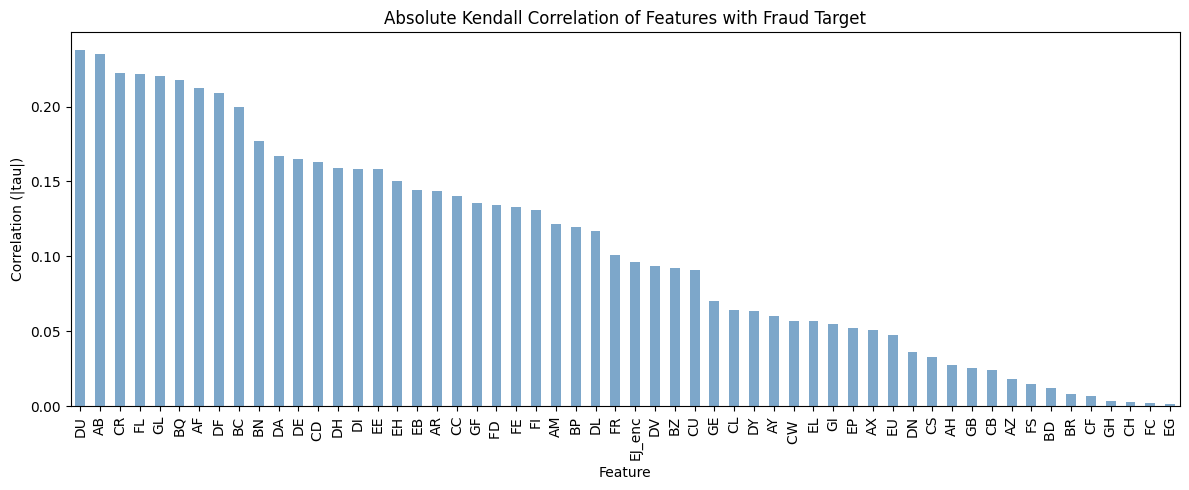

In [9]:
# To visualize all feature correlations (absolute values)
spearman_df = pd.DataFrame(spearman_results, columns=['Feature', 'Spearman']).set_index('Feature')
kendall_df = pd.DataFrame(kendall_results, columns=['Feature', 'Kendall']).set_index('Feature')

plt.figure(figsize=(12,5))
spearman_df['Spearman'].abs().sort_values(ascending=False).plot(kind='bar', color='orange', alpha=0.7)
plt.title("Absolute Spearman Correlation of Features with Fraud Target")
plt.ylabel("Correlation (|r|)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
kendall_df['Kendall'].abs().sort_values(ascending=False).plot(kind='bar', color='steelblue', alpha=0.7)
plt.title("Absolute Kendall Correlation of Features with Fraud Target")
plt.ylabel("Correlation (|tau|)")
plt.tight_layout()
plt.show()


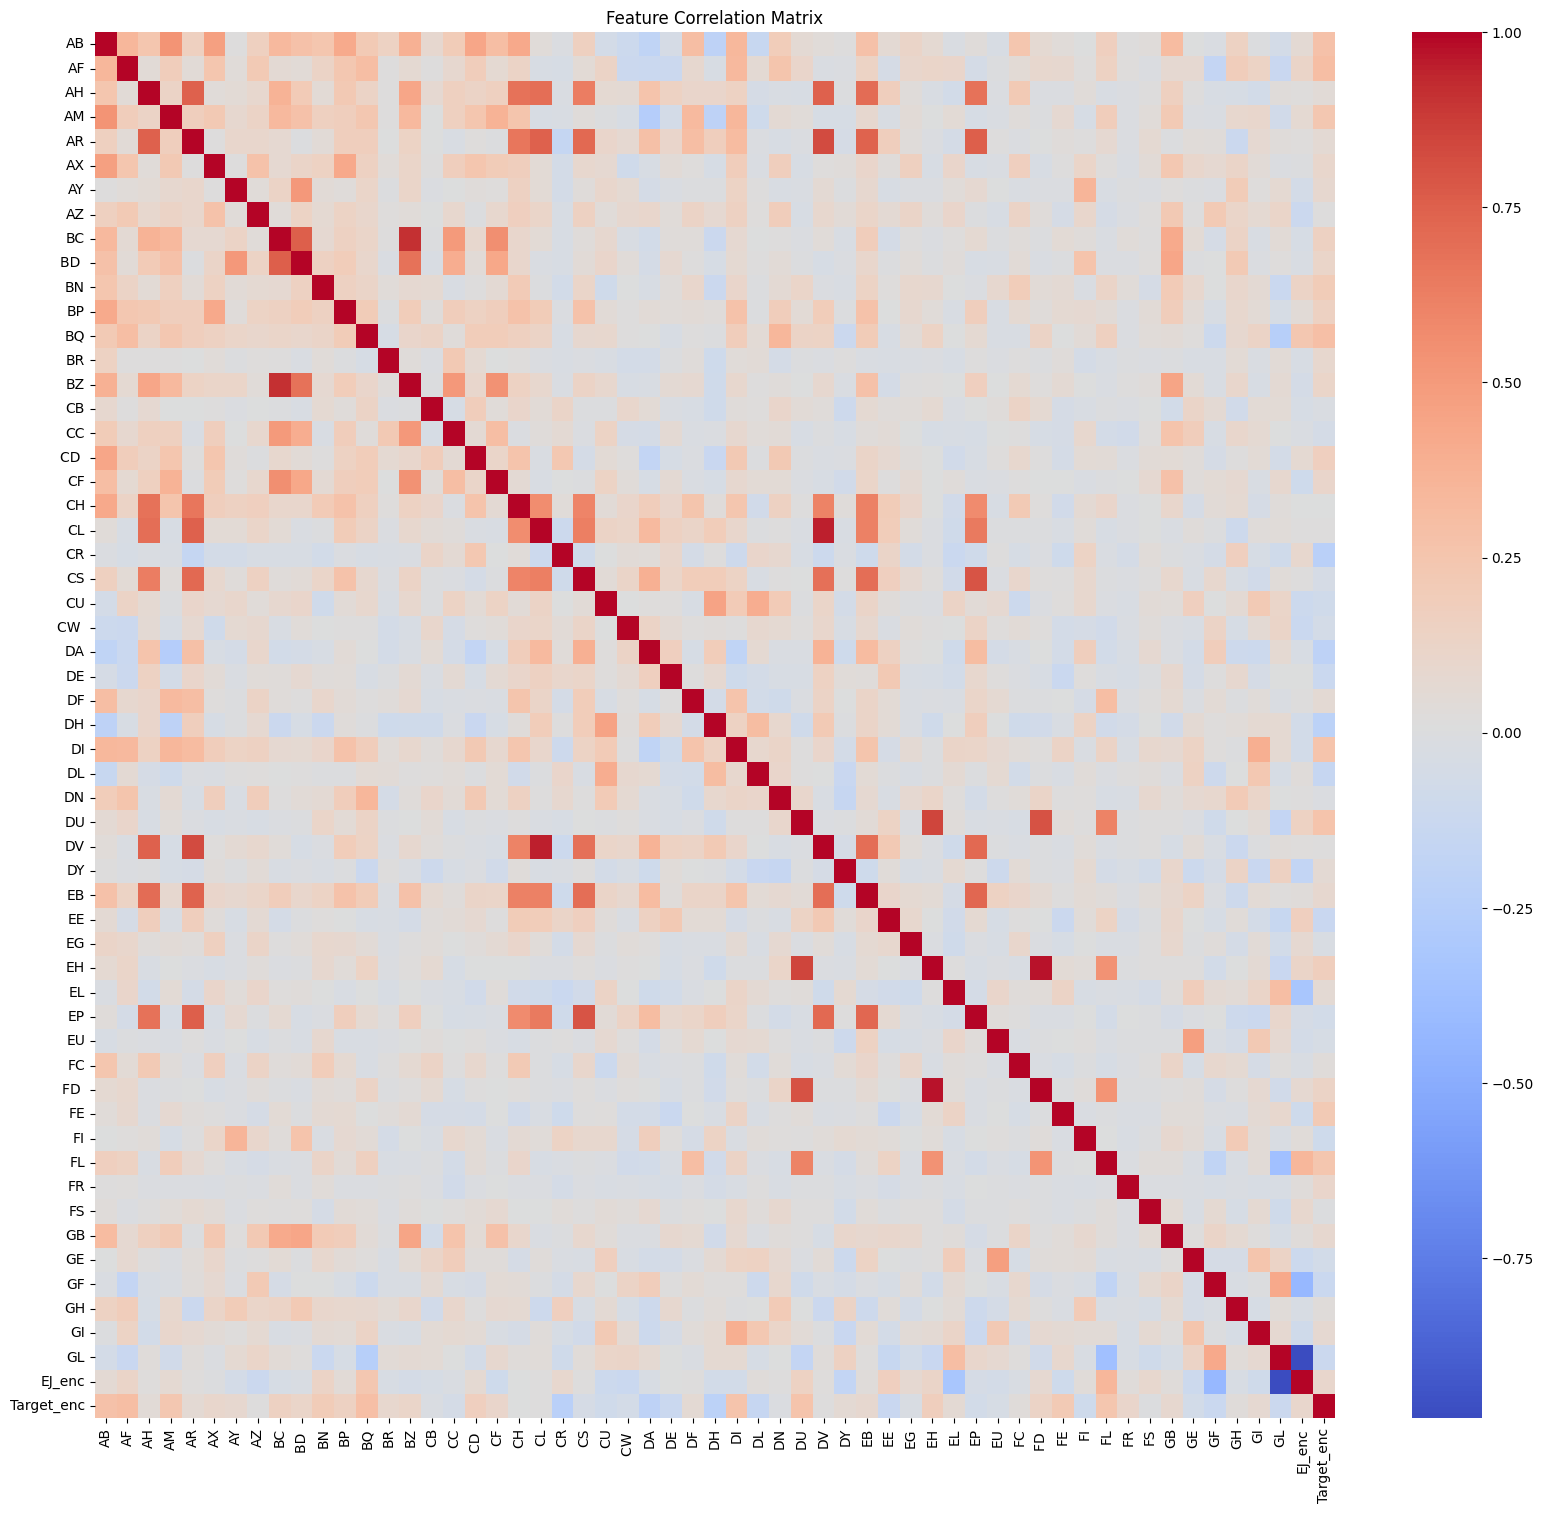

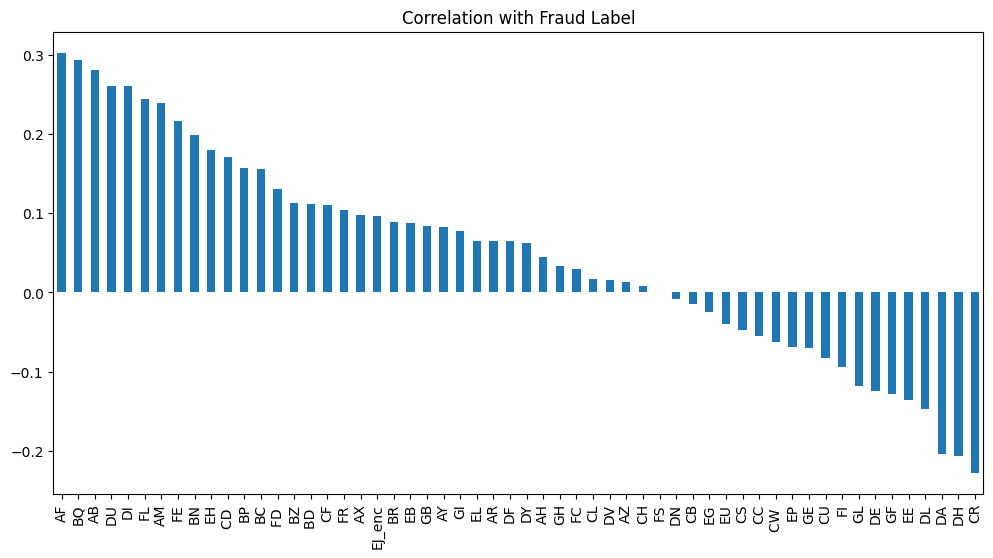

In [10]:
# Correlation matrix for numeric features only
numeric_cols = feature_cols + ['Target_enc']
corr = df[numeric_cols].corr()

# Correlation with fraud label
target_corr = corr['Target_enc'].drop('Target_enc').sort_values(ascending=False)

# Plot heatmap
plt.figure(figsize=(20,18))
sns.heatmap(corr, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# Plot barplot
target_corr.plot(kind='bar', figsize=(12,6), title='Correlation with Fraud Label')
plt.show()

In [11]:
X = df[feature_cols]
y = df['Target_enc']

In [ ]:
X_binned = df[feature_cols].copy()
for col in X_binned.columns:
    # Only discretize if enough unique values
    if X_binned[col].nunique() > 10:
        X_binned[col] = pd.qcut(X_binned[col], q=25, duplicates='drop', labels=False)
    # Otherwise (already near-discrete), keep as is

# Compute mutual information (all as discrete now)
mi = mutual_info_classif(X_binned, df["Target_enc"], discrete_features=True, random_state=42)

# Output results
mi_df = pd.DataFrame({'Feature': feature_cols, 'Mutual Information': mi})
mi_df = mi_df.sort_values('Mutual Information', ascending=False)
print(mi_df.head(10))

   Feature  Mutual Information
32      DU            0.116796
54      GL            0.085915
12      BQ            0.077589
46      FL            0.074352
25      DA            0.070892
29      DI            0.065390
0       AB            0.064284
1       AF            0.063521
21      CR            0.062471
45      FI            0.053554


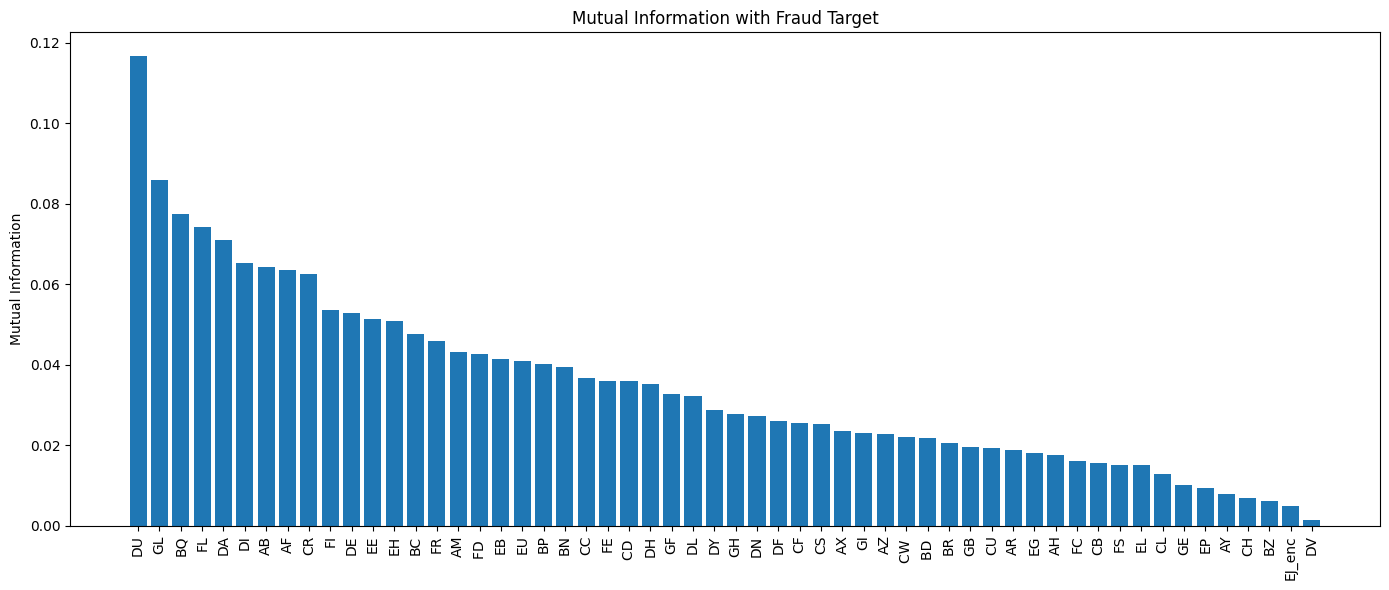

In [53]:
plt.figure(figsize=(14,6))
plt.bar(mi_df['Feature'], mi_df['Mutual Information'])
plt.xticks(rotation=90)
plt.title("Mutual Information with Fraud Target")
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.show()

Skewness measures the asymmetry of a distribution. Positive skewness means the tail is longer on the right (high values are more spread out); negative skewness means the left tail (low values) dominates. Skewness values above 1 (or below –1) are generally considered highly skewed.
Most columns show very high skewness (values far larger than 1), indicating a long right tail.
This is typical for features like transaction amounts, network activity, or event counts, where most values are small but a few are exceptionally large.

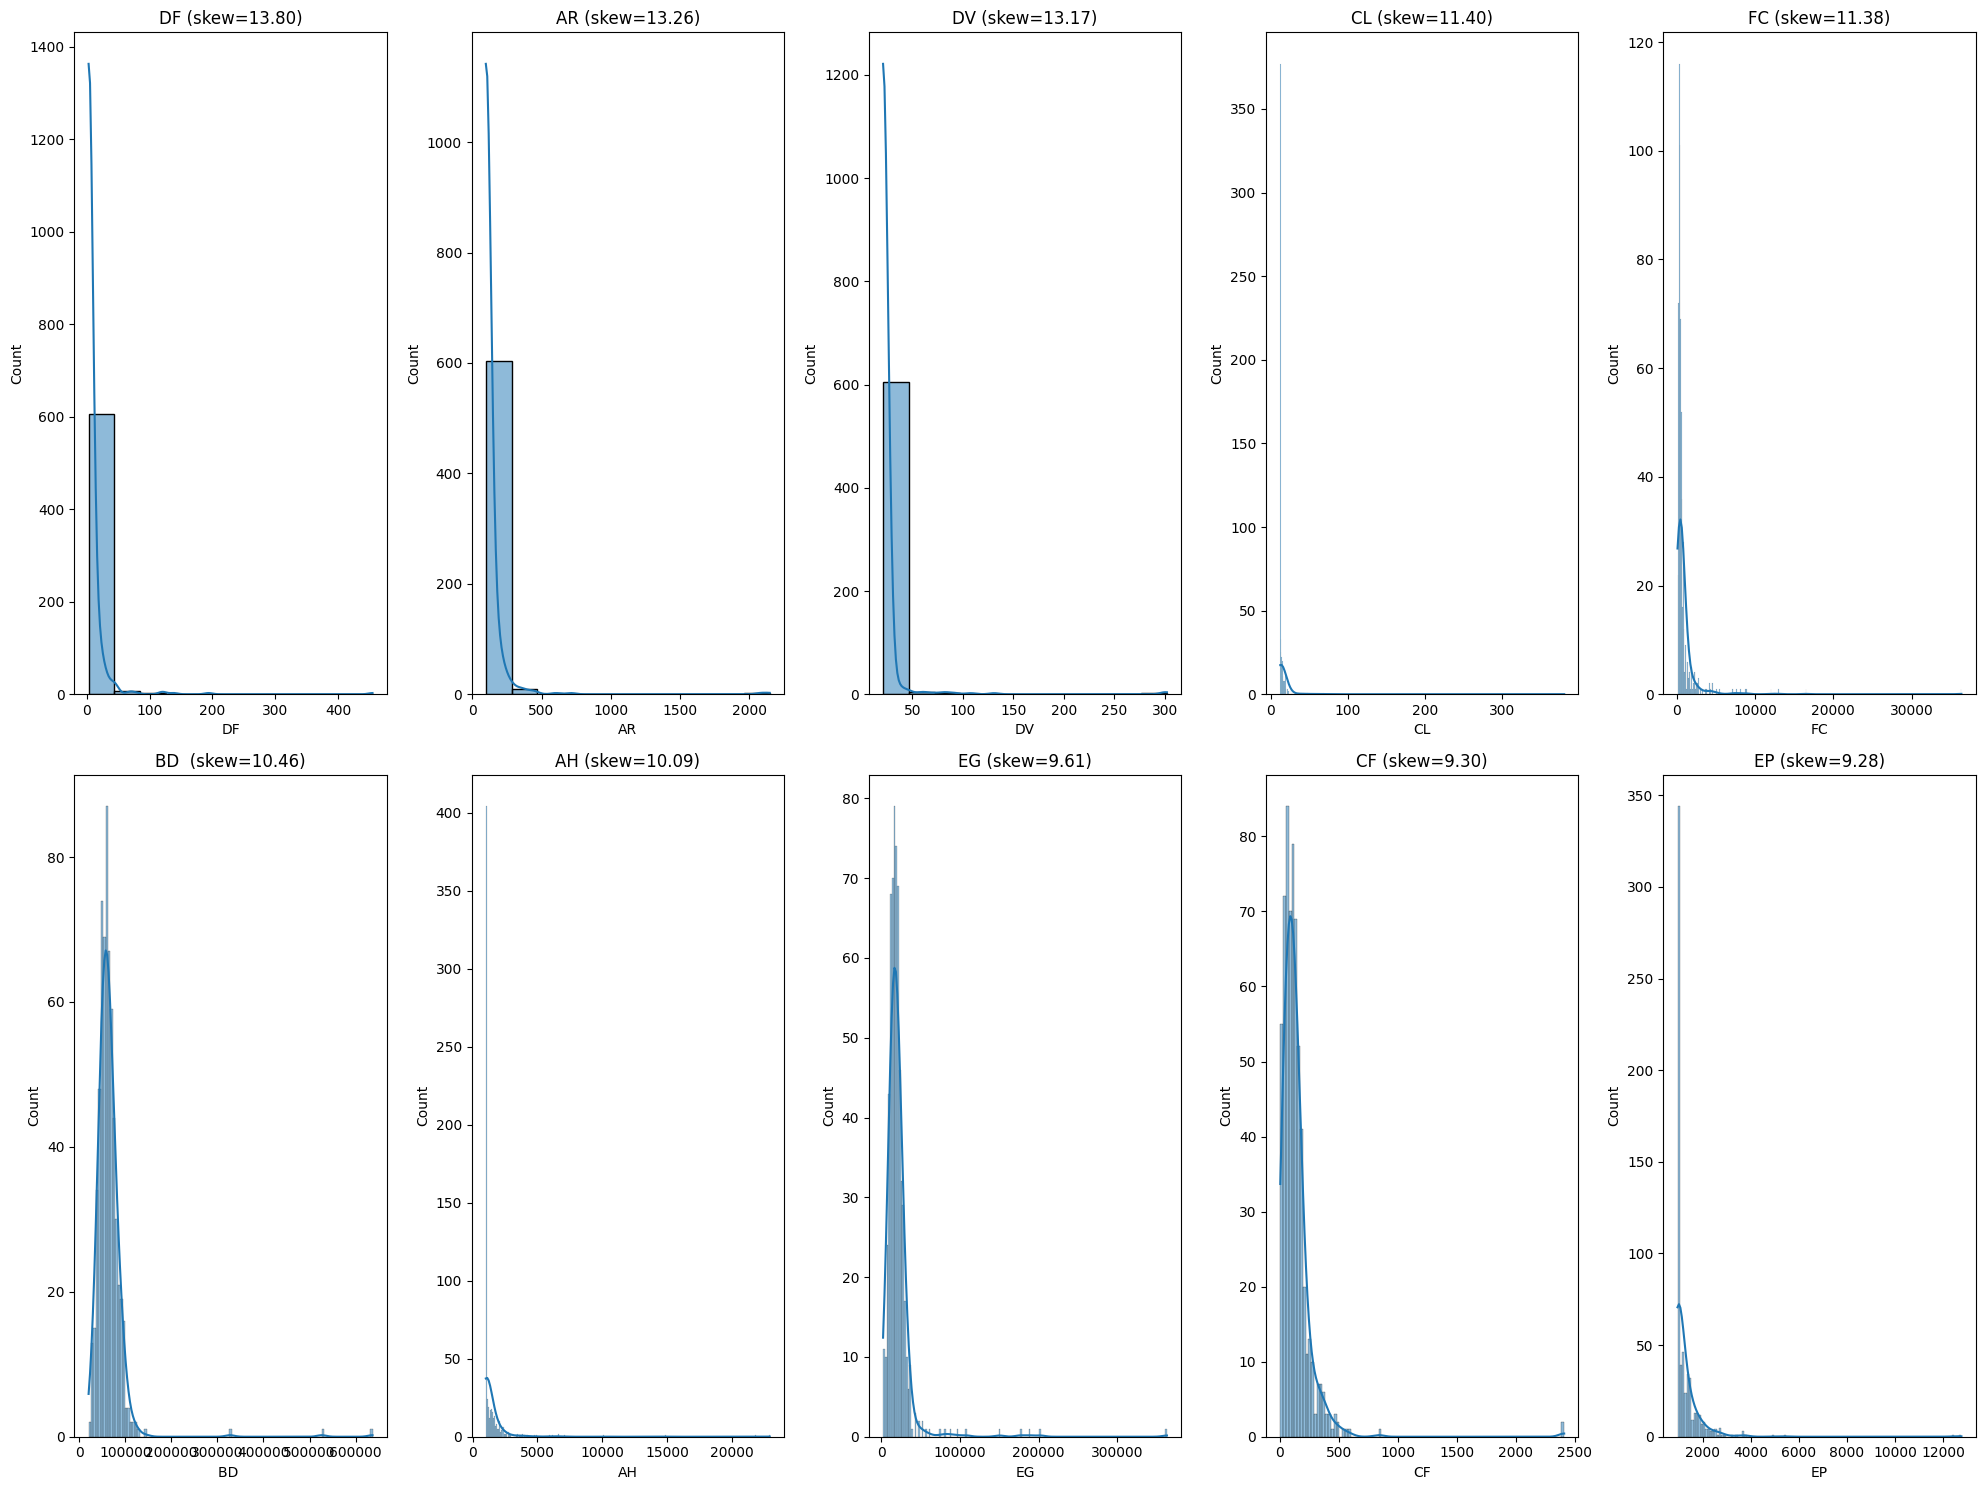

In [ ]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Plot distributions and calculate skewness for first 10 columns to check skew
sample_cols = numeric_cols
skewness = df[numeric_cols].skew().sort_values(ascending=False)
top_skewed = skewness[skewness.abs() > 1]  # Only consider highly skewed features
sample_cols = skewness.index[10:20]
# Plot histograms for these numeric columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(sample_cols):
    plt.subplot(2, 5, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'{col} (skew={skewness[col]:.2f})')
plt.tight_layout()
plt.show()

In [17]:
top_skewed.count()

np.int64(47)

In [42]:
def distance_correlation(x, y):
    """ Compute distance correlation between two arrays"""
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    n = x.shape[0]
    a = np.abs(x[:, None] - x)
    b = np.abs(y[:, None] - y)
    A = a - a.mean(axis=0) - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0) - b.mean(axis=1)[:, None] + b.mean()
    dcov2 = (A * B).sum() / (n**2)
    dvarx = (A * A).sum() / (n**2)
    dvary = (B * B).sum() / (n**2)
    return 0 if dvarx == 0 or dvary == 0 else np.sqrt(dcov2) / np.sqrt(np.sqrt(dvarx * dvary))

results = []
for col in feature_cols:
    dcorr = distance_correlation(df[col].values, df['Target_enc'].values)
    results.append((col, dcorr))

results_sorted = sorted(results, key=lambda x: abs(x[1]), reverse=True)
results_sorted = pd.DataFrame(results_sorted, columns=['Feature', 'Distance Correlation']).set_index('Feature')
results_sorted

,Distance Correlation
Feature,
DU,0.429801
FL,0.328834
AB,0.298775
BQ,0.296445
CR,0.281181
AF,0.280896
DI,0.280768
EH,0.270296
FE,0.234023
